In [3]:
# standard library imports
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
from sklearn.metrics import roc_auc_score, roc_curve

# plot style parameters
plt.rcParams['text.usetex']    = True
plt.rcParams['font.family']    = 'serif'
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi']     = 100

In [4]:
# function to add a stamp to figures
def stamp(left_x, top_y, 
          line_0=None, 
          line_1=r'$e^+e^- \to H \to q\bar{q}/gg$', 
          line_2=r'\textsc{Pythia} 8.235, \textsc{Dire} 2.003',
          line_3=r'$\sqrt{s}=200$ GeV, Partons',
          delta_y=0.055,
          textops_update={},
          ax=None,
          **kwargs):
    
    textops = {'horizontalalignment': 'left', 'verticalalignment': 'center', 'fontsize': 8.5}
    textops.update(textops_update)
    if ax is None: ax = plt.gca()
    textops['transform'] = ax.transAxes
    kwargs.update({'line_0': line_0, 'line_1': line_1, 'line_2': line_2, 'line_3': line_3})
    for i in range(len(kwargs)):
        y = top_y - i*delta_y
        t = kwargs.get('line_' + str(i))
        if t is not None:
            ax.text(left_x, y, t, **textops)

In [5]:
# function to read in and process the events
def readin(filename, rotate=False, num=-1):
    event, events = [], []
    with open(filename) as f:
        for row in f:
            # read in a particle as [E, px, py, pz, m, PID]
            particle = np.asarray(row.split(), dtype=float)

            # events are separated by newlines
            if len(particle) == 0:
                events.append(np.asarray(event))
                event = []
                
            # append the particle to the event
            else: event.append(particle)
                
            # read in the specified number of events
            if len(events) == num: break     
    
    # (Euclidean) rotation to standardize events based on principal axes 
    if rotate:
        rot90z = np.asarray([[0,-1,0],[1,0,0],[0,0,1]])
        for i in range(len(events)):
            # calculate the second moment of the energy flow
            moment = np.zeros((3,3))
            for E,px,py,pz,m,ID in events[i]:
                phat = np.asarray([px,py,pz])/np.sqrt(px**2 + py**2 + pz**2)
                moment += E*np.outer(phat, phat)
            moment /= np.sum(events[i], axis=0)[0]  

            # rotate the momenta correspondingly
            eigvals, eigvecs = np.linalg.eigh(moment)
            R = eigvecs[:,::-1]
            events[i][:,1:4] = np.einsum('ij,kj->ki', np.dot(rot90z,R.T), events[i][:,1:4])

    return events

In [60]:
# read in the events
num = 100000
rotate = False

qlabls, glabls = [], []
quarks, gluons = [], []

#specify which events to readin
for (CF,CA) in [('000','300'), ('033','300'), ('067','300'), ('100','300'), ('133','300'), ('167','300'), ('200','300'),
                     ('233','300'),  ('267','300'),  ('300','300')]:
    qq_filename = '../events/qq_events_CF{}_CA{}.txt'.format(CF,CA)
    quarks.append(readin(qq_filename, rotate=rotate, num=num))
    qlabls.append('Q: CF'+CF+'CA'+CA)
    print("Quarks", CF, CA, len(quarks[-1]))

for (CF,CA) in [('300','300')]:
    gg_filename = '../events/gg_events_CF{}_CA{}.txt'.format(CF,CA)
    gluons.append(readin(gg_filename, rotate=rotate, num=num))
    glabls.append('G: CF'+CF+'CA'+CA)
    print("Gluons", CF, CA, len(gluons[-1]))

Quarks 000 300 100000
Quarks 033 300 100000
Quarks 067 300 100000
Quarks 100 300 100000
Quarks 133 300 100000
Quarks 167 300 100000
Quarks 200 300 100000
Quarks 233 300 100000
Quarks 267 300 100000
Quarks 300 300 100000
Gluons 300 300 100000


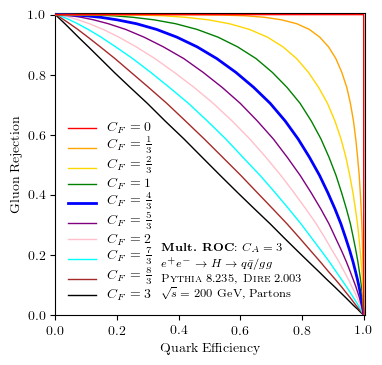

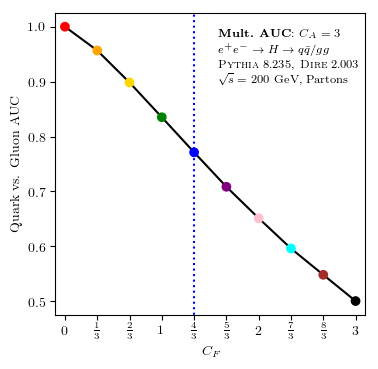

In [116]:
colors = ['red','orange','gold','green','blue','purple', 'pink', 'cyan', 'brown', 'black']
labs = [r'$C_F=0$',r'$C_F=\frac13$',r'$C_F=\frac23$',r'$C_F=1$', r'$C_F=\frac43$',
        r'$C_F=\frac53$',r'$C_F=2$',r'$C_F=\frac73$',r'$C_F=\frac83$',r'$C_F=3$']

aucs = []

gjets = gluons[0]
for i, qjets in enumerate(quarks):
    qmults, gmults = [len(jet) for jet in qjets], [len(jet) for jet in gjets]
    
    mults  = np.concatenate([qmults, gmults])
    labels = np.concatenate([np.ones(len(qmults)), np.zeros(len(gmults))])
    aucs.append(roc_auc_score(labels, -mults))

    fp,tp,_ = roc_curve(labels, -mults)
    plt.plot(np.concatenate([[0],tp]), np.concatenate([[1],1-fp]), '-',
             color=colors[i], label=labs[i], zorder=10-i, lw=1 if i!=4 else 2)

plt.xlim(0,1.005); plt.ylim(0,1.005);
plt.legend(loc='lower left', frameon=False, ncol=1, labelspacing=0.25)
stamp(0.34,0.22, line_0=r'{\bf Mult. ROC}: $C_A=3$', delta_y=0.05)
plt.xlabel('Quark Efficiency'); plt.ylabel('Gluon Rejection')
#plt.savefig('plots/multroc.pdf', bbox_inches='tight')
plt.show()
    
    
plt.plot([0.0000, 0.3333, 0.6666, 1.000, 1.3333, 1.6666, 2.0000, 2.3333, 2.6666, 3.0000], aucs, '-', color='black')    
plt.scatter([0.0000, 0.3333, 0.6666, 1.000, 1.3333, 1.6666, 2.0000, 2.3333, 2.6666, 3.0000], aucs, color=colors, zorder=5)


xs = np.linspace(0,3,100)
#plt.plot(xs,1-1/6*xs)
plt.plot([4/3, 4/3], [0, 2], ':', color='blue')

plt.xticks(np.linspace(0.0, 3.0, 10), [r'$0$',r'$\frac13$',r'$\frac23$',r'$1$',r'$\frac43$',
                                      r'$\frac53$',r'$2$',r'$\frac73$',r'$\frac83$',r'3'])
plt.xlim(-0.1,3.1); plt.ylim(0.475, 1.025);
plt.xlabel(r'$C_F$'); plt.ylabel(r'Quark vs. Gluon AUC');
stamp(0.525,0.93, line_0=r'{\bf Mult. AUC}: $C_A=3$', delta_y=0.05)
#plt.savefig('plots/multauc.pdf', bbox_inches='tight')
plt.show()

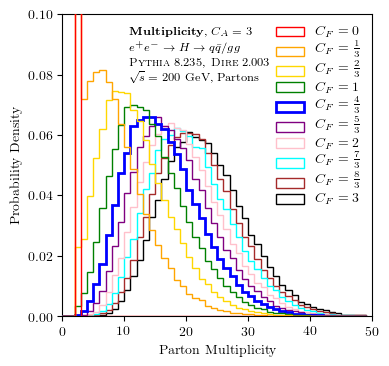

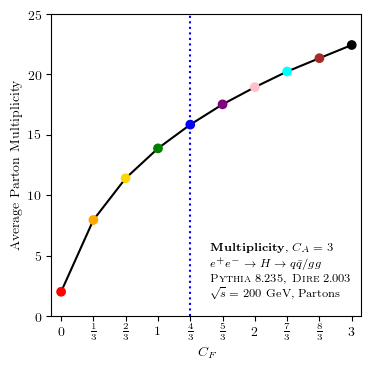

In [150]:
colors = ['red','orange','gold','green','blue','purple', 'pink', 'cyan', 'brown', 'black']
labs = [r'$C_F=0$',r'$C_F=\frac13$',r'$C_F=\frac23$',r'$C_F=1$', r'$C_F=\frac43$',
        r'$C_F=\frac53$',r'$C_F=2$',r'$C_F=\frac73$',r'$C_F=\frac83$',r'$C_F=3$']

meanms = []

gjets = gluons[0]
for i, qjets in enumerate(quarks):
    mults = [len(jet) for jet in qjets]
    
    meanms.append(np.mean(mults))
    
    plt.hist(mults, bins=np.arange(50), histtype='step', density=True, label=labs[i],
             color=colors[i], zorder=10-i, lw=1 if i!=4 else 2)
    
plt.xlim(0, 50); plt.ylim(0,0.1);
plt.legend(loc='upper right', frameon=False, ncol=1, labelspacing=0.25)
stamp(0.215,0.94, line_0=r'{\bf Multiplicity}, $C_A=3$', delta_y=0.05)
plt.xlabel('Parton Multiplicity'); plt.ylabel('Probability Density')
#plt.savefig('plots/multdist.pdf', bbox_inches='tight')
plt.show()

plt.plot([0.0000, 0.3333, 0.6666, 1.000, 1.3333, 1.6666, 2.0000, 2.3333, 2.6666, 3.0000], meanms, '-', color='black')    
plt.scatter([0.0000, 0.3333, 0.6666, 1.000, 1.3333, 1.6666, 2.0000, 2.3333, 2.6666, 3.0000], meanms, color=colors, zorder=5)


xs = np.linspace(0,3,100)
#plt.plot(xs,1-1/6*xs)
plt.plot([4/3, 4/3], [0, 30], ':', color='blue')

plt.xticks(np.linspace(0.0, 3.0, 10), [r'$0$',r'$\frac13$',r'$\frac23$',r'$1$',r'$\frac43$',
                                      r'$\frac53$',r'$2$',r'$\frac73$',r'$\frac83$',r'3'])
plt.xlim(-0.1,3.1); plt.ylim(0, 25);
plt.xlabel(r'$C_F$'); plt.ylabel(r'Average Parton Multiplicity');
stamp(0.51,0.225, line_0=r'{\bf Multiplicity}, $C_A=3$', delta_y=0.05)
#plt.savefig('plots/multmean.pdf', bbox_inches='tight')
plt.show()

In [ ]:
1-4/9

In [5]:
def mass(event):
    efp = ef.EFP([(0,1)], measure='ee', coords='epxpypz', beta=1, normed=True)
    return efp.compute(event[:,:4])

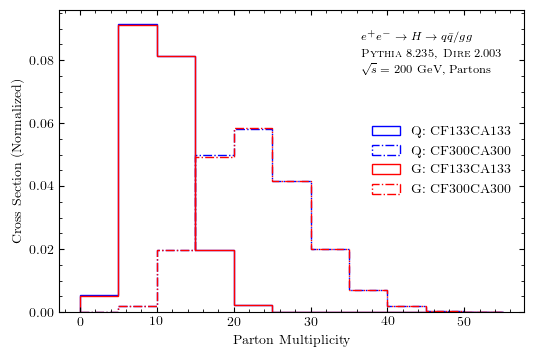

In [7]:
bins = np.arange(0,60,5)

lss = ['-', '-.', ':', '--']
for i, events in enumerate(quarks):
    mults = np.asarray([len(event) for event in events])
    plt.hist(mults, bins=bins, histtype='step', density=True, color='blue', label=qlabls[i], ls=lss[i])

for i, events in enumerate(gluons):
    mults = np.asarray([len(event) for event in events])
    plt.hist(mults, bins=bins, histtype='step', density=True, color='red', label=glabls[i], ls=lss[i])

# tick settings
plt.gca().minorticks_on()
plt.gca().tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    
plt.xlabel(r'Parton Multiplicity'); plt.ylabel('Cross Section (Normalized)');
plt.legend(loc='center right', frameon=False, ncol=1)
stamp(0.65, 0.965)    
plt.show()

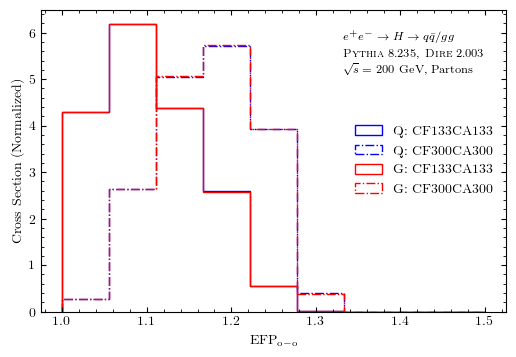

In [10]:
bins = np.linspace(1,1.5,10)

lss = ['-', '-.', ':', '--']
for i, events in enumerate(quarks):
    masss = np.asarray([mass(event) for event in events])
    plt.hist(masss, bins=bins, histtype='step', density=True, color='blue', label=qlabls[i], ls=lss[i])
    
for i, events in enumerate(gluons):
    masss = np.asarray([mass(event) for event in events])
    plt.hist(masss, bins=bins, histtype='step', density=True, color='red', label=glabls[i], ls=lss[i])


# tick settings
plt.gca().minorticks_on()
plt.gca().tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    
plt.xlabel(r'EFP$_{\mathrm{o-o}}$'); plt.ylabel('Cross Section (Normalized)');
plt.legend(loc='center right', frameon=False, ncol=1)
stamp(0.65, 0.965)    
plt.show()

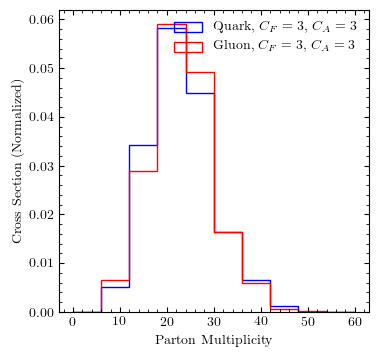

In [82]:
bins = np.linspace(0,60,11)

for mult, lab, ls in zip(mults_q, labels_q, styles):
    plt.hist(mult, histtype='step', density='True', bins=bins, label=lab, color='blue', ls=ls)
    
for mult, lab, ls in zip(mults_g, labels_g, styles):
    plt.hist(mult, histtype='step', density='True', bins=bins, label=lab, color='red', ls=ls)
    
plt.gca().minorticks_on()
plt.gca().tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')
    
plt.xlabel('Parton Multiplicity'); plt.ylabel('Cross Section (Normalized)');
plt.legend(loc='upper right', frameon=False, ncol=1)

#plt.xlim(min(bins), max(bins)); plt.ylim(0, 0.18);

#plt.savefig('../figures/qgmults.pdf', bbox_inches='tight')

plt.show()

In [69]:
import math as m

from vector import Vec4
from particle import Particle

class Algorithm:

    def Yij(self,p,q):
        pq = p.px*q.px+p.py*q.py+p.pz*q.pz
        return 2.*pow(min(p.E,q.E),2)*(1.0-min(max(pq/m.sqrt(p.P2()*q.P2()),-1.0),1.0))/self.ecm2

    def Cluster(self,event):
        self.ecm2 = (event[0].mom+event[1].mom).M2()
        p = [ i.mom for i in event[2:] ]
        kt2 = []
        n = len(p)
        imap = [l for l in range(n)]
        kt2ij = [ [ 0 for i in range(n) ] for j in range(n) ]
        dmin = 1
        for i in range(n):
            for j in range(i):
                dij = kt2ij[i][j] = self.Yij(p[i],p[j])
                if dij < dmin: dmin = dij; ii = i; jj = j
        while n>2:
            n -= 1
            kt2.append(dmin);
            jjx = imap[jj]
            p[jjx] += p[imap[ii]]
            for i in range(ii,n): imap[i] = imap[i+1]
            for j in range(jj): kt2ij[jjx][imap[j]] = self.Yij(p[jjx],p[imap[j]])
            for i in range(jj+1,n): kt2ij[imap[i]][jjx] = self.Yij(p[jjx],p[imap[i]])
            dmin = 1
            for i in range(n):
                for j in range(i):
                    dij = kt2ij[imap[i]][imap[j]]
                    if dij < dmin: dmin = dij; ii = i; jj = j
        return kt2

import yoda

class Analysis:

    def __init__(self):
        self.n = 0.
        self.ynm = [ yoda.Histo1D(100,-4.3,-0.3,path='/LL_JetRates/log10_y_{0}{1}\n'.format(i+2,i+3)) for i in range(4) ]
        self.duralg = Algorithm()

    def Analyze(self,event,w):
        self.n += 1.
        kt2 = self.duralg.Cluster(event)
        for j in range(len(self.ynm)):
            self.ynm[j].fill(m.log10(kt2[-1-j]) if len(kt2)>j else -5.,w)

    def Finalize(self,name):
        for h in self.ynm: h.scaleW(1./self.n)
        yoda.core.writeYODA(self.ynm,name+".yoda")

In [19]:
import math as m
import random as r

from vector import Vec4
from particle import Particle

class eetojj:

    def __init__(self,ecms=91.2):
        self.ecms = ecms
        self.MZ2 = pow(91.1876,2.)
        self.GZ2 = pow(2.4952,2.)
        self.alpha = 1./128.802
        self.sin2tw = 0.22293

    def ME2(self,fl,s,t):
        qe = -1.
        ae = -0.5
        ve = ae - 2.*qe*self.sin2tw;
        qf = 2./3. if fl in [2,4] else -1./3.
        af = 0.5 if fl in [2,4] else -0.5
        vf = af - 2.*qf*self.sin2tw;
        kappa = 1./(4.*self.sin2tw*(1.-self.sin2tw))
        chi1 = kappa * s * (s-self.MZ2)/(pow(s-self.MZ2,2.) + self.GZ2*self.MZ2);
        chi2 = pow(kappa * s,2.)/(pow(s-self.MZ2,2.) + self.GZ2*self.MZ2);
        term1 = (1+pow(1.+2.*t/s,2.))*(pow(qf*qe,2.)+2.*(qf*qe*vf*ve)*chi1+(ae*ae+ve*ve)*(af*af+vf*vf)*chi2)
        term2 = (1.+2.*t/s)*(4.*qe*qf*ae*af*chi1+8.*ae*ve*af*vf*chi2)
        return pow(4.*m.pi*self.alpha,2.)*3.*(term1+term2)

    def GeneratePoint(self):
        ct = 2.*r.random()-1.
        st = m.sqrt(1.-ct*ct)
        phi = 2.*m.pi*r.random()
        p1 = Vec4(self.ecms/2.,self.ecms/2.*st*m.cos(phi),self.ecms/2.*st*m.sin(phi),self.ecms/2.*ct)
        p2 = Vec4(p1.E,-p1.px,-p1.py,-p1.pz)
        pa = Vec4(self.ecms/2.,0.,0.,self.ecms/2.)
        pb = Vec4(self.ecms/2.,0.,0.,-self.ecms/2.)
        fl = r.randint(1.,5.)
        dxs = 5.*self.ME2(fl,(pa+pb).M2(),(pa-p1).M2())
        dxs *= 3.89379656e8/(8.*m.pi)/(2.*pow(self.ecms,2))
        color = r.choice([1,2,3])
        return ( [
            Particle(-11,-pa),
            Particle(11,-pb),
            Particle(fl,p1,[1,0]),
            Particle(-fl,p2,[0,1])
        ], dxs )

In [57]:
event = eetojj().GeneratePoint()
event[0]

[-11 (-45.6,-0.0,-0.0,-45.6) [0, 0],
 11 (-45.6,-0.0,-0.0,45.6) [0, 0],
 2 (45.6,-21.606931791402282,26.150219406536884,30.474030313558316) [1, 0],
 -2 (45.6,21.606931791402282,-26.150219406536884,-30.474030313558316) [0, 1]]

In [55]:
Algorithm().Cluster(event[0])

[]

In [118]:
def y23(events):
    vals = []
    for event in events:
        ev = []

        ev.append(Particle(-11, Vec4(-100,0,0,-100)))
        ev.append(Particle(+11, Vec4(-100,0,0,+100)))

        for p in event:
            ev.append(Particle(0,Vec4(*p[:4])))

            
        cluster = Algorithm().Cluster(ev)
        if len(cluster) < 2: continue
        vals.append(cluster[-1])
        
    return -np.log(np.asarray(vals))

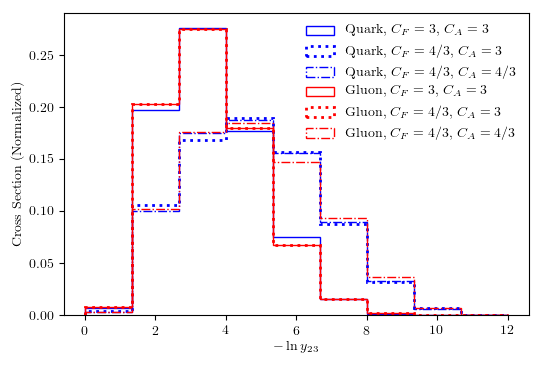

In [158]:
bins = np.linspace(0,12,10)

plt.hist(y23(quarks_CF3_CA3),ls='-', bins=bins, histtype='step', density=True, color='blue', label=r'Quark, $C_F=3$, $C_A=3$')
#plt.hist(y23(quarks_CF3_CA43),ls='--', bins=bins, histtype='step', density=True, color='blue', label=r'Quark, $C_F=3$, $C_A=4/3$')
plt.hist(y23(quarks_CF43_CA3),ls=':', lw=2, bins=bins, histtype='step', density=True, color='blue',label=r'Quark, $C_F=4/3$, $C_A=3$')
plt.hist(y23(quarks_CF43_CA43),ls='-.', bins=bins, histtype='step', density=True, color='blue',label=r'Quark, $C_F=4/3$, $C_A=4/3$')

plt.hist(y23(gluons_CF3_CA3),ls='-', bins=bins, histtype='step', density=True, color='red', label=r'Gluon, $C_F=3$, $C_A=3$')
#plt.hist(y23(gluons_CF3_CA43),ls='--', bins=bins, histtype='step', density=True, color='red', label=r'Gluon, $C_F=3$, $C_A=4/3$')
plt.hist(y23(gluons_CF43_CA3),ls=':', lw=2, bins=bins, histtype='step', density=True, color='red', label=r'Gluon, $C_F=4/3$, $C_A=3$')
plt.hist(y23(gluons_CF43_CA43),ls='-.', bins=bins, histtype='step', density=True, color='red', label=r'Gluon, $C_F=4/3$, $C_A=4/3$')

plt.legend(loc='upper right', frameon=False)
plt.xlabel(r"$-\ln y_{23}$"); plt.ylabel(r"Cross Section (Normalized)")
#plt.savefig('lny23.pdf', bbox_inches='tight')
plt.show()

In [165]:
gluons_CF3_CA3[0]

array([[ 36.9115 ,  22.5144 , -22.4821 , -18.7113 ,   0.     ,  21.     ],
       [ 69.9294 , -31.1044 , -50.4538 ,  37.1086 ,   0.     ,  21.     ],
       [ 23.1284 ,  -2.58184,  14.2026 ,  18.0704 ,   0.     ,  21.     ],
       [ 70.0308 ,  11.1718 ,  58.7333 , -36.4677 ,   0.     ,  21.     ]])

In [167]:
gluons_CF43_CA3[0]

array([[ 36.9115 ,  22.5144 , -22.4821 , -18.7113 ,   0.     ,  21.     ],
       [ 69.9294 , -31.1044 , -50.4538 ,  37.1086 ,   0.     ,  21.     ],
       [ 23.1284 ,  -2.58184,  14.2026 ,  18.0704 ,   0.     ,  21.     ],
       [ 70.0308 ,  11.1718 ,  58.7333 , -36.4677 ,   0.     ,  21.     ]])

In [88]:
nums = [12.567,
293.986,
901.352,
6172.430,
33521.114,
114843.687,
392659.479,
2284792.618,
2333280.071,
1414462.687,
20.585,
539.491,
1474.722,
10583.561,
59292.115,
208109.103,
800844.351,
2284792.618,
2284792.618,
1.841,
45.628,
298.084,
2061.075,
4314.114,
25144.074,
48487.453,
48487.453,
1414462.687,
1414462.687]

In [89]:
np.sum(nums)

15189154.250999998